In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import os, sys
from PIL import Image
from tqdm import tqdm
import time

In [2]:
def get_energy(image, scale=3000):
    # extract energy bar from image
    ebar_bounds = ((5,8),(145,17))
    ebar = image[ebar_bounds[0][0]:ebar_bounds[1][0], ebar_bounds[0][1]:ebar_bounds[1][1], :]

    ebar_slice = np.array([np.mean(ebar[i,1,:]) for i in range(ebar.shape[0])]) # 1d slice of energy bar
    for i in range(ebar_slice.shape[0]):
        if ebar_slice[i] != 255:
            break
    proportion_filled = 1 - (i-1)/ebar_slice.shape[0] # proportion of energy bar filled (0-1)
    event_energy = (proportion_filled * scale) # scale to max energy
    event_energy += 27.766 # offset to match data
    return event_energy

In [3]:
def get_track(image):
    # extract padplane from image
    padplane_bounds = ((3,40),(148,185))
    padplane = image[padplane_bounds[0][0]:padplane_bounds[1][0], padplane_bounds[0][1]:padplane_bounds[1][1], :]
    
    # extract track from padplane
    track = padplane[:,:,0].copy() # copy red channel for track
    track[track == 255] = 0 # set white to black
    track_bounds = np.where(track != 0) # get track bounds
    track_bounds = ((min(track_bounds[0]), max(track_bounds[0])+1), (min(track_bounds[1]), max(track_bounds[1])+1))
    track = track[track_bounds[0][0]:track_bounds[0][1], track_bounds[1][0]:track_bounds[1][1]] # crop track
    track = track[::4,::4] # downsample track to remove grid effect
    return track

In [4]:
def get_trace(image):
    trace_img = image[150:,:,0] # extract trace from image
    trace_cumsum = np.cumsum(255-trace_img, axis=0) # cumulative sum of trace
    trace = trace_cumsum[-1,:].astype(float) # height of trace at each pixel
    
    trace_diff = np.abs(np.diff(trace))
    edges = np.arange(trace_diff.shape[0])[trace_diff > 100] # find edges of trace
    
    # crop trace_height to edges
    trace = trace[edges[0]+5:edges[-1]-5]
    
    # set baseline to average of first and last 10 pixels
    baseline = np.mean(np.concatenate((trace[:10], trace[-10:])))
    trace -= baseline # subtract baseline
    trace[trace < 0] = 0 # set negative values to 0
    
    return trace

In [5]:
def analyze_trace(trace):
    tsum1 = np.cumsum(trace)
    tsum2 = np.cumsum(trace[::-1])[::-1]
    # find edges of trace peak
    cutoff=np.mean(trace) 
    ledge=np.arange(tsum1.shape[0])[tsum1 >= cutoff][0]
    redge=np.arange(tsum2.shape[0])[tsum2 >= cutoff][-1]
    
    trace_width = redge - ledge # width of trace peak
    
    trace = trace[ledge:redge] # crop trace to edges
    
    trace_max = np.max(trace) # peak height of trace
    trace_avg = np.mean(trace) # average height of trace (ignoring baseline)
    
    # determine number of peaks in trace
    trace_diff = np.diff(trace)
    trace_diff = np.convolve(trace_diff, np.ones(5), mode='same') # smooth trace_diff with moving average
    trace_diff[trace_diff <= 0] = -1 # set negative values to -1
    trace_diff[trace_diff > 0] = 1 # set positive values to 1
    trace_diff = -1*np.diff(trace_diff) # separate to only look for changes in slope direction
    num_peaks = np.sum(trace_diff > 0) # number of peaks in trace
    
    return trace_width, trace_max, trace_avg, num_peaks

In [6]:
def analyze_track(track):
    length = (track.shape[0]**2 + track.shape[1]**2)**0.5 # length of track
    num_pads = track[track>0].reshape(-1).shape[0] # pads in track
    width = num_pads / length # width of track
    
    # number of pixels in track larger than all surrounding pixels in 3x3 window
    num_peaks = np.sum(track[1:-1,1:-1] > np.max(np.array([track[:-2,:-2], track[:-2,1:-1], track[:-2,2:], track[1:-1,:-2], track[1:-1,2:], track[2:,:-2], track[2:,1:-1], track[2:,2:]]), axis=0))
    
    # pad energy statistics
    track = track[track > 0] # remove 0s
    max_pad = np.max(track) # highest measured pad energy
    min_pad = np.min(track) # lowest measured pad energy
    avg_pad = np.mean(track) # average pad energy
    
    return length, width, num_pads, num_peaks, max_pad, min_pad, avg_pad

In [7]:
def get_event_length(length, trace_width):
    # weight of trace in length calculation
    # obtained by minimizing the standard deviation of the length calculation for events of the same energy
    trace_weight = 0.59176
    
    scale = 1/2.2 # scale factor for length calculation (pads to mm)
    overshoot = 0 # overshoot of length calculation (mm)
    
    return scale*(length**2 + trace_weight*trace_width**2)**0.5 - overshoot

In [8]:
image_dir = "/mnt/analysis/e17023/Adam/GADGET2/simOutput/images/"
i = 0
try:
    data_df = pd.read_csv("/mnt/analysis/e17023/Adam/GADGET2/Analysis/event_data.csv")
except:
    data_df = pd.DataFrame(columns=[
        'sim','event', # from image name
        'energy', # from energy bar
        'trace_width','trace_max','trace_avg','trace_peaks', # from trace
        'track_length','track_width','num_pads','track_peaks','max_pad','min_pad','avg_pad', # from track
        'event_length', 'num_peaks', # calculated from track and trace
        ])
pre_processed = data_df['sim'].values + '_image_' + data_df['event'].values.astype(str) + '.png'
file_list = [f for f in os.listdir(image_dir) if f.endswith('.png')]
file_list = [f for f in file_list if f not in pre_processed]

In [9]:
for i in tqdm(range(len(file_list))):
    img = file_list[i]
    # name of image and event
    sim_name = img.split('_')[0]
    event = img.split('_')[-1].split('.')[0]
    
    img_array = np.array(Image.open(image_dir + img))[:,:,:3]
    # extract data from image
    event_energy = get_energy(img_array)
    track = get_track(img_array)
    trace = get_trace(img_array)

    # normalize energy
    track = event_energy * track / np.sum(track) # assumes all energy is represented in track pixels, bad with high threshold
    trace = event_energy * trace / np.sum(trace)

    trace_width, trace_max, trace_avg, trace_peaks = analyze_trace(trace)
    track_length, track_width, num_pads, track_peaks, max_pad, min_pad, avg_pad = analyze_track(track)

    event_length = get_event_length(track_length, trace_width)
    num_peaks = np.max((trace_peaks, track_peaks))

    data_df.loc[len(data_df.index)] = [sim_name, event,
                        event_energy,
                        trace_width, trace_max, trace_avg, trace_peaks,
                        track_length, track_width, num_pads, track_peaks, max_pad, min_pad, avg_pad,
                        event_length, num_peaks
                        ]
# clean data
int_cols = ['event', 'trace_peaks', 'num_pads', 'track_peaks', 'num_peaks', 'trace_width']
float_cols = ['energy', 'trace_max', 'trace_avg', 'track_length', 'track_width', 'max_pad', 'min_pad', 'avg_pad', 'event_length']
data_df[int_cols] = data_df[int_cols].astype(int)
data_df[float_cols] = data_df[float_cols].astype(float).round(3)

  0%|          | 0/9800 [00:00<?, ?it/s]

100%|██████████| 9800/9800 [01:57<00:00, 83.54it/s]


In [10]:
# save data
data_df.to_csv('event_data.csv', index=False)

In [11]:
# sort in same order as parameters.csv
param_df = pd.read_csv('/mnt/analysis/e17023/Adam/GADGET2/simInput/parameters.csv')
param_df = param_df[param_df['Status'] >= 3] # only completed sims

In [12]:
# Per-Simulation Data Analysis
analysis_cols = ['sim', 'N']
for col in data_df.columns:
    if col not in ['sim', 'event']:
        analysis_cols.append(col)
        analysis_cols.append(col + '_std')

sim_data_df = pd.DataFrame(columns=analysis_cols)
for sim in param_df['Sim'].unique():
    if sim in data_df['sim'].unique():
        sim_data = data_df[data_df['sim'] == sim]
        sim_data_df.loc[sim, 'sim'] = sim
        sim_data_df.loc[sim, 'N'] = sim_data.shape[0]
        for col in sim_data.columns:
            if col not in ['sim', 'event']:
                sim_data_df.loc[sim, col] = np.mean(sim_data[col])
                sim_data_df.loc[sim, col + '_std'] = np.std(sim_data[col])
sim_data_df.to_csv('sim_data.csv', index=False)

In [13]:
def display_event(sim, event):
    img = f"{sim}_image_{event}.png"
    img_array = np.array(Image.open(image_dir + img))[:,:,:3]
    event_energy = get_energy(img_array)
    track = get_track(img_array)
    trace = get_trace(img_array)
    
    print(f"{img} | {event_energy} keV")
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].imshow(img_array) 
    ax[1].imshow(track, cmap='inferno')
    ax[2].plot(trace, color='black')
    
    # hide axes for 0 and 1
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()
    return 0

VarSimCDA7_image_79.png | 2192.0517142857143 keV


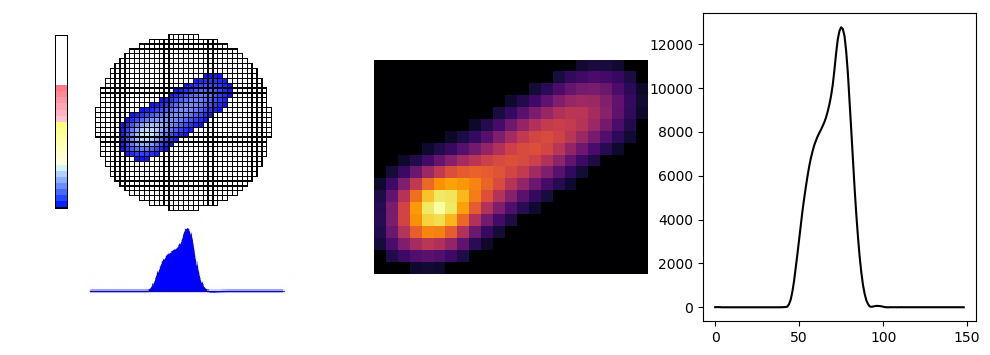

VarSimCDA137_image_28.png | 2192.0517142857143 keV


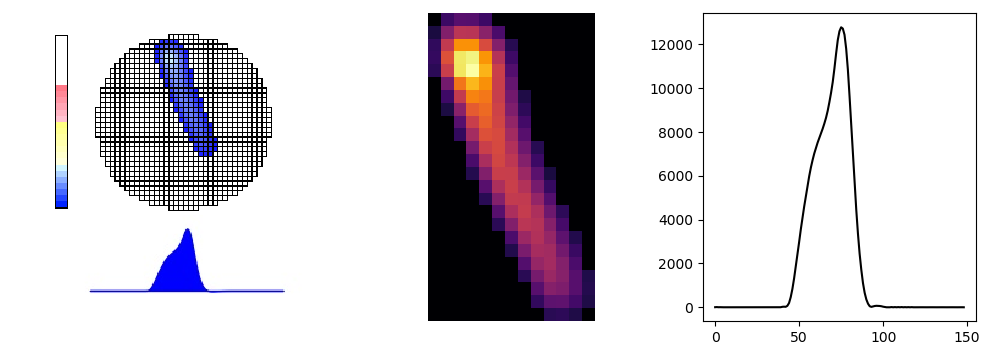

VarSimCDA7_image_10.png | 2084.9088571428574 keV


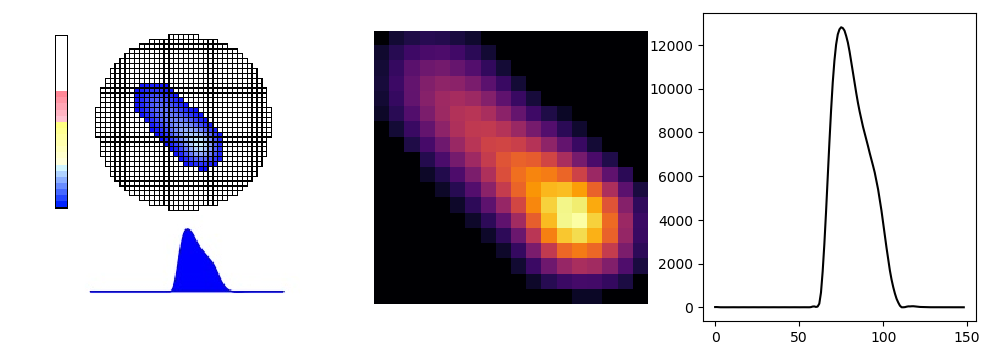

VarSimCDA177_image_51.png | 1977.766 keV


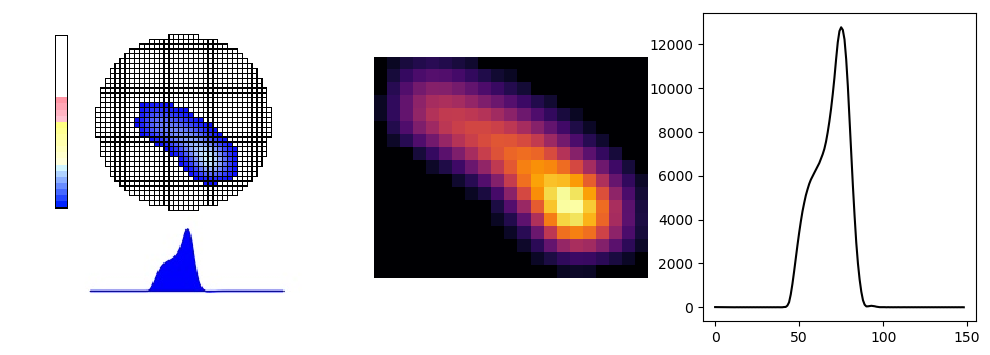

VarSimCDA137_image_4.png | 2192.0517142857143 keV


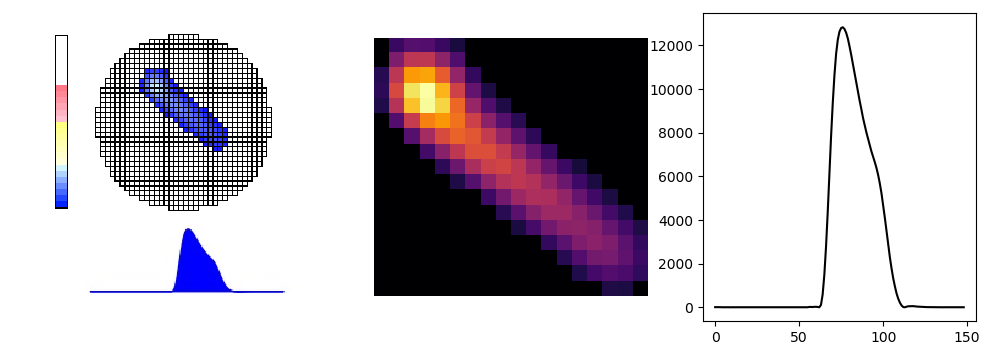

VarSimCDA185_image_68.png | 2084.9088571428574 keV


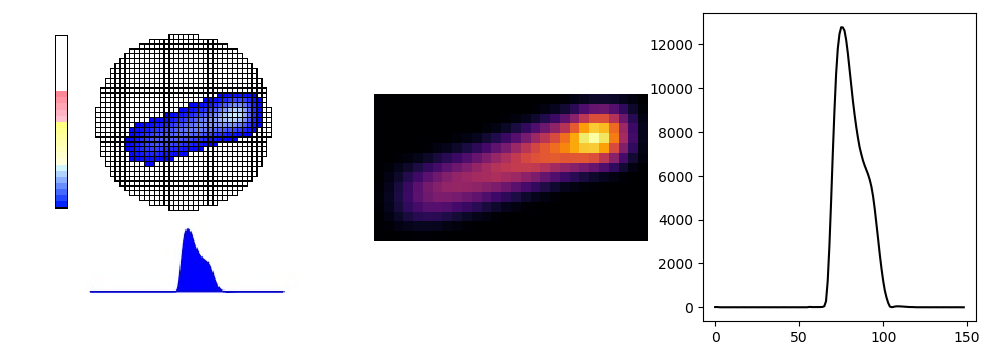

VarSimCDA51_image_63.png | 2192.0517142857143 keV


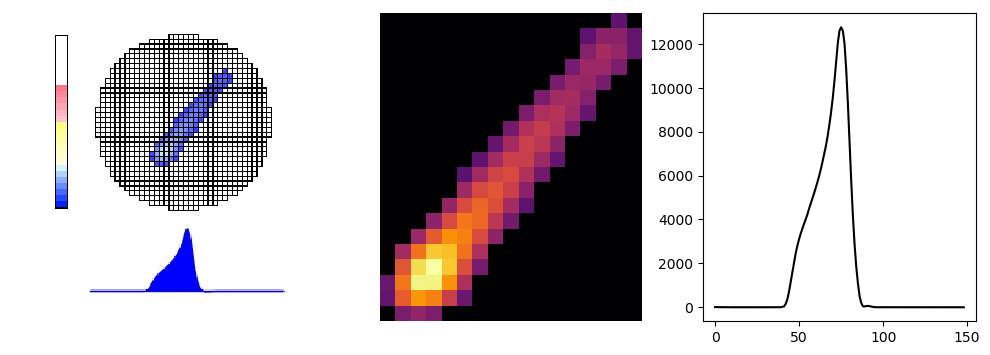

VarSimCDA177_image_2.png | 2084.9088571428574 keV


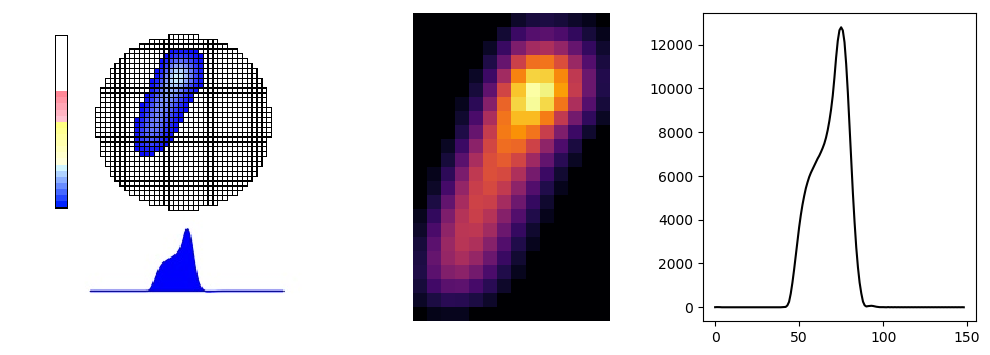

VarSimCDA177_image_23.png | 1977.766 keV


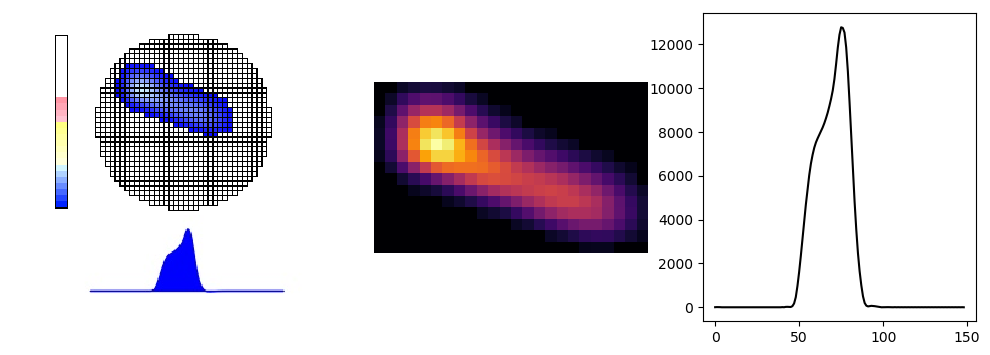

VarSimCDA33_image_7.png | 1977.766 keV


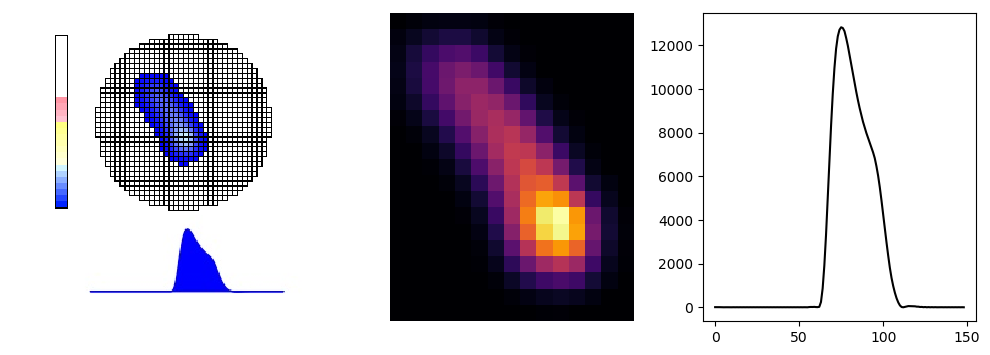

In [14]:
data_df.sort_values(by=['event_length'], inplace=True, ascending=False)
for [sim, event] in data_df[['sim','event']].values[:10]:
    display_event(sim, event)